## Classify and count sea lions from image

In [1]:
INPUT_DIR = '../../input/kaggle-sea-lion/'
OUTPUT_DIR = '../../output/kaggle-sea-lion/10/'

IMAGE_DIMS = (42,42,3)
LABEL_DIMS = (6,)
LOAD_WEIGHTS_FILE = INPUT_DIR + '05/weights-medium1-42x42-0.94.h5'
LOAD_MODEL_FILE = None
DEBUG = False
IMAGE_SLICE = slice(1400,1800)

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import sklearn
import os
import glob
import cv2

from modules.logging import logger
import modules.utils as utils
from modules.utils import Timer
import modules.logging
import modules.cnn as cnn
import modules.lions as lions
import modules.objectdetect as objectdetect

Using TensorFlow backend.


### Prepare output dir

In [3]:
utils.mkdirs(OUTPUT_DIR, recreate=True)
modules.logging.setup_file_logger(OUTPUT_DIR + 'out.log')
logger.info('Dir ' + OUTPUT_DIR + ' created')

2017-06-03 15:26:59,546 INFO Dir ../../output/kaggle-sea-lion/10/ created


In [4]:
#from MismatchedTrainImages.txt
MISMATCHED = [3, 7, 9, 21, 30, 34, 71, 81, 89, 97, 151, 184, 215, 234, 242, 268, 290, 311, 331, 344, 380, 384, 406, 421, 469, 475, 490, 499, 507, 530, 531, 605, 607, 614, 621, 638, 644, 687, 712, 721, 767, 779, 781, 794, 800, 811, 839, 840, 869, 882, 901, 903, 905, 909, 913, 927, 946]


## Explore lion classification using CNN

### Load trained CNN model

In [5]:
logger.info('Load CNN model')

#lion simple cnn forward time: ~10ms
print(LOAD_WEIGHTS_FILE)
model = lions.convnet_medium1_lion_keras(IMAGE_DIMS)
model.load_weights(LOAD_WEIGHTS_FILE)

2017-06-03 15:26:59,601 INFO Load CNN model
/notebooks/datascience-snippets/kaggle-sea-lion/modules/lions.py:69: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", kernel_initializer="glorot_uniform", padding="same")`
  model.add(convolutional.Conv2D(64, (3, 3), activation='relu', padding='same', init='glorot_uniform'))
/notebooks/datascience-snippets/kaggle-sea-lion/modules/lions.py:71: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", kernel_initializer="glorot_uniform", padding="same")`
  model.add(convolutional.Conv2D(128, (3, 3), activation='relu', padding='same', init='glorot_uniform'))
/notebooks/datascience-snippets/kaggle-sea-lion/modules/lions.py:73: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu", kernel_initializer="glorot_uniform", padding="same")`
  model.add(convolutional.Conv2D(256, (3, 3), activation='relu', padding='same', i

../../input/kaggle-sea-lion/05/weights-medium1-42x42-0.94.h5


### Perform sliding window search

In [6]:
img_path = INPUT_DIR + 'Train/42.jpg'
img = cv2.imread(img_path)
img = img[IMAGE_SLICE]

imgd_path = INPUT_DIR + 'TrainDotted/42.jpg'
imgd = cv2.imread(imgd_path)
imgd = imgd[IMAGE_SLICE]

#img = img[1800:2500,3000:4000]
#img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY).astype('u1')

""" Returns (score, label) """
def eval_region(region_img):
    y_pred = model.predict(np.array([region_img]))
    ylp = utils.onehot_to_label(np.array(y_pred))
    return y_pred[0][ylp[0]], ylp[0]

img2 = img.copy()

region_generator = objectdetect.sliding_window_generator(img2, step=(19,19), window=IMAGE_DIMS, pyramid_firstscale=None, pyramid_scale=0.65, pyramid_max_layers=1)
detections, imgs = objectdetect.evaluate_regions(region_generator, eval_region, filter_score_min=0.97, 
                                                 filter_labels=(0,1,2,3,4), apply_non_max_suppression=True, 
                                                 supression_overlap_threshold=0.0, threads=None)

print('regions found:')
print(len(detections))

2017-06-03 15:27:00,533 INFO pyramid layer=0 image=(400, 4992, 3) scale=1
2017-06-03 15:27:00,535 INFO > [started] sliding_window...


(400, 4992, 3)
399/400 [=========================>] 99% 32s remaining=0s sliding windoww

2017-06-03 15:27:33,521 INFO > [done]    sliding_window (32985.821 ms)
2017-06-03 15:27:33,523 INFO > [started] non_max_suppression. boxes=1378607...
2017-06-03 15:27:38,199 INFO > [done]    non_max_suppression. boxes=1378607 (4676.044 ms)


regions found:
26


### Show results

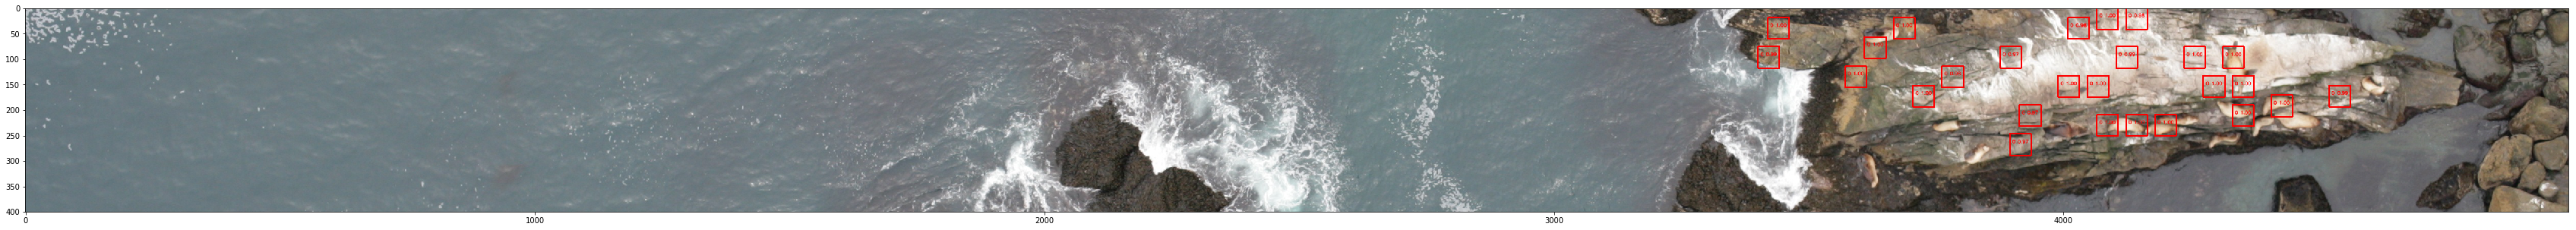

2017-06-03 15:27:40,322 INFO showing 26 images
2017-06-03 15:27:40,325 INFO > [started] generating image patches. rows=3; cols=10...


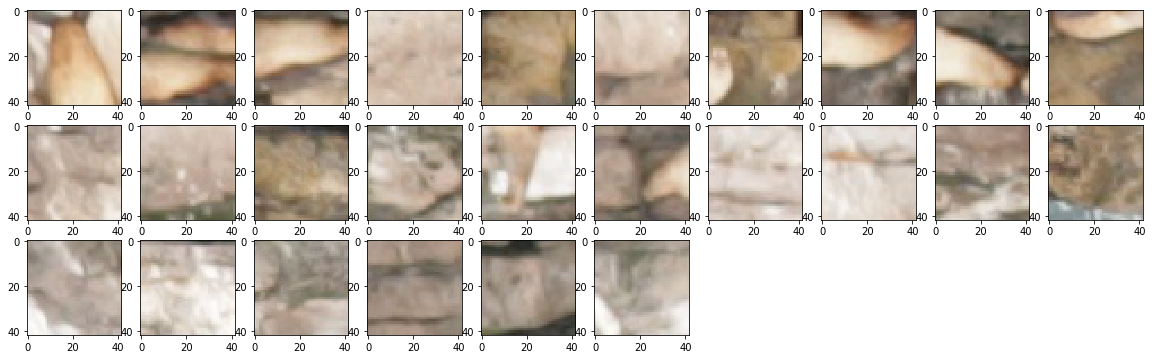

2017-06-03 15:27:42,494 INFO > [done]    generating image patches. rows=3; cols=10 (2168.586 ms)


In [7]:
def detection_to_colortext(detection):
    score = detection[4]
    text = str(int(detection[5])) + ' ' + '{0:.2f}'.format(score)
    c = int(score*255)
    return (0,0,c), text

objectdetect.draw_detections(detections, img2, detection_to_colortext)
utils.show_image(img2, size=60, is_bgr=True)

patches = objectdetect.extract_patches(detections, img)
utils.show_images(patches[0:50], size=2, cols=10, is_bgr=True)

### Verify classification/count performance

2017-06-03 15:27:42,540 INFO sea lions found: 15
2017-06-03 15:27:42,541 INFO sea lions added to dataset: 15
2017-06-03 15:27:42,544 INFO non sea lions added to dataset: 0


  ground positives: 15
detected positives: 26
   false positives: 21
    true positives: 5
  overall accuracy: 0.33


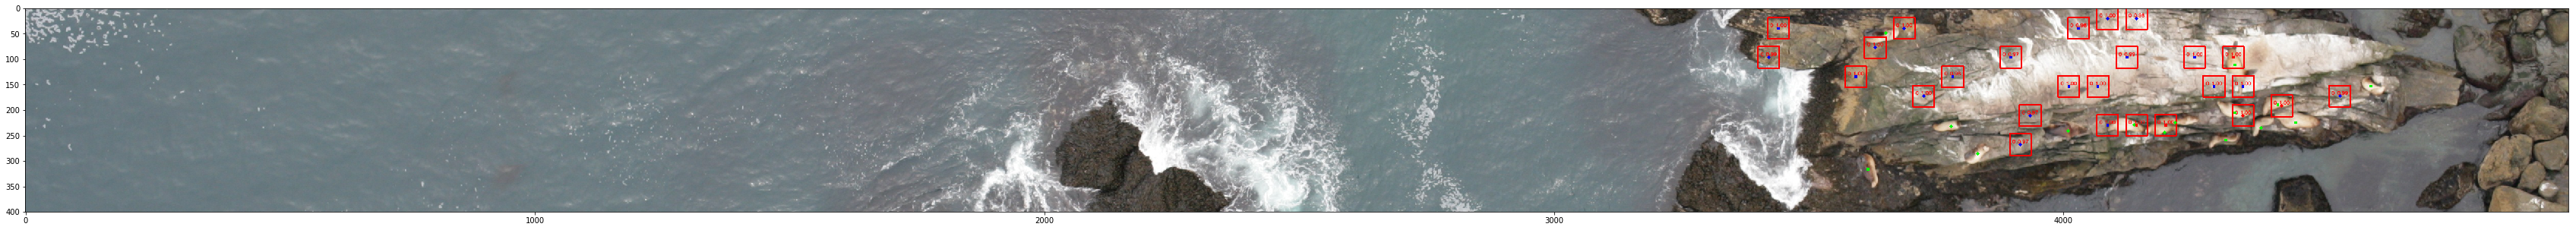

2017-06-03 15:27:44,613 INFO showing 21 images
2017-06-03 15:27:44,618 INFO > [started] generating image patches. rows=3; cols=10...


false positives (red is OK, blue are false positives)


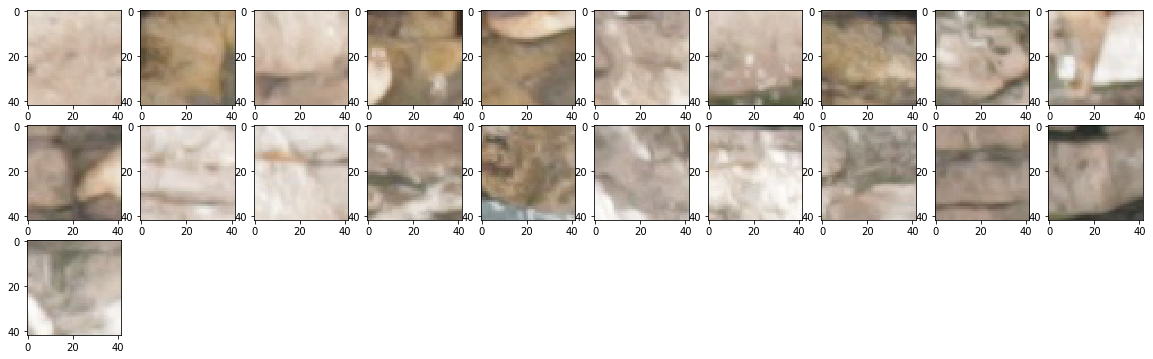

2017-06-03 15:27:46,417 INFO > [done]    generating image patches. rows=3; cols=10 (1798.452 ms)


In [8]:
classes_count_total,classes_count_added,lion_positions,lion_classes = lions.export_lions(img, imgd, None, None, IMAGE_DIMS, debug=False, min_distance_others=0, export_non_lion=False)
#print(lion_positions)

for i,lp in enumerate(lion_positions):
    cv2.circle(img2, lp, 3, (0,255,0), -5)

false_positives = []
true_positives = []
#print(lion_positions)
for i,detection in enumerate(detections):
    patch_pos = (int(detection[1]+detection[3]/2),int(detection[0]+detection[2]/2))
    is_far = utils.is_far_from_others(patch_pos, lion_positions, 30)
#    print(str(i) + ' ' + str(patch_pos) + ' ' + str(is_far))
    
    color = (0,0,255)
    if(is_far):
        color = (255,0,0)
        false_positives.append(detection)
    else:
        true_positives.append(detection)
    cv2.circle(img2, patch_pos, 3, color, -5)

fp = objectdetect.extract_patches(false_positives, img)

print('  ground positives: ' + str(len(lion_positions)))
print('detected positives: ' + str(len(detections)))
print('   false positives: ' + str(len(false_positives)))
print('    true positives: ' + str(len(true_positives)))
print('  overall accuracy: ' + '{0:.2f}'.format(len(true_positives)/len(lion_positions)))

utils.show_image(img2, is_bgr=True, size=60)
print('false positives (red is OK, blue are false positives)')
utils.show_images(fp, size=2, cols=10, is_bgr=True)

## Export false positive samples

### Prepare output dataset

In [9]:
x_ds = None
y_ds = None

logger.info('creating dataset')
dataset_path = OUTPUT_DIR + utils.dataset_name('lion-patches-false-positives', IMAGE_DIMS)
h5file = h5py.File(dataset_path, 'w')
x_ds, y_ds = utils.create_xy_dataset(h5file, IMAGE_DIMS, LABEL_DIMS, x_dtype='u1')
logger.info('done')

2017-06-03 15:27:46,425 INFO creating dataset
2017-06-03 15:27:46,432 INFO done


### Find and export all false positives

In [10]:
#from MismatchedTrainImages.txt
MISMATCHED = [3, 7, 9, 21, 30, 34, 71, 81, 89, 97, 151, 184, 215, 234, 242, 268, 290, 311, 331, 344, 380, 384, 406, 421, 469, 475, 490, 499, 507, 530, 531, 605, 607, 614, 621, 638, 644, 687, 712, 721, 767, 779, 781, 794, 800, 811, 839, 840, 869, 882, 901, 903, 905, 909, 913, 927, 946]
logger.info('loading train.csv')
train = pd.read_csv(INPUT_DIR + "Train/train.csv")
FORCE_IMAGES = [41]

2017-06-03 15:27:46,455 INFO loading train.csv


In [11]:
logger.info('process all photos from train file')

""" Returns (score, label) """
def eval_region(region_img):
    y_pred = model.predict(np.array([region_img]))
    ylp = utils.onehot_to_label(np.array(y_pred))
    return y_pred[0][ylp[0]], ylp[0]

total_lions = np.zeros(LABEL_DIMS[0]-1)
total_false_positives = np.zeros(LABEL_DIMS[0]-1)
total_true_positives = np.zeros(LABEL_DIMS[0]-1)
for row in train.itertuples():
    #load images
    train_id = row[1]
    
    if(FORCE_IMAGES!=None and train_id not in FORCE_IMAGES):
        continue
    
    image_raw_file = INPUT_DIR + 'Train/'+ str(train_id) +'.jpg'
    image_dotted_file = INPUT_DIR + 'TrainDotted/'+ str(train_id) +'.jpg'

    if(train_id in MISMATCHED):
        logger.warning('skipping mismatched train_id ' + str(train_id))
        continue
    
    if(not os.path.isfile(image_raw_file)):
        logger.warning('file not found. skipping. file=' + image_raw_file)
        continue

    t = Timer('processing photo ' + image_raw_file)
    image_raw = cv2.imread(image_raw_file)
    image_raw = image_raw[IMAGE_SLICE]
    image_dotted = cv2.imread(image_dotted_file)
    image_dotted = image_dotted[IMAGE_SLICE]

    #extract ground truth
    classes_count_total,classes_count_added,lion_positions,lion_classes = lions.export_lions(image_raw, image_dotted, None, None, IMAGE_DIMS, debug=DEBUG, min_distance_others=0, export_non_lion=False)
    for lc in lion_classes:
        total_lions[lc] += 1
    
    #search for lions
    region_generator = objectdetect.sliding_window_generator(image_raw, step=(19,19), window=IMAGE_DIMS, pyramid_max_layers=1, pyramid_scale=0.75)
    detections, imgs = objectdetect.evaluate_regions(region_generator, eval_region, filter_score_min=0.97, 
                                                     filter_labels=(0,1,2,3,4), apply_non_max_suppression=True, 
                                                     supression_overlap_threshold=0.08, threads=None)
    #compare ground truth to found lions
    false_positives = np.zeros(LABEL_DIMS[0]-1)
    false_positives_patches = []
    true_positives = np.zeros(LABEL_DIMS[0]-1)
    for i,detection in enumerate(detections):
        patch_pos = (int(detection[1]+detection[3]/2),int(detection[0]+detection[2]/2))
        is_far = utils.is_far_from_others(patch_pos, lion_positions, 30)
        if(is_far):
            false_positives[int(detection[5])] += 1
            false_positives_patches.append(detection)
        else:
            true_positives[int(detection[5])] += 1

    total_false_positives = np.add(total_false_positives, false_positives)
    total_true_positives = np.add(total_true_positives, true_positives)

    print('  ground positives: ' + str(len(lion_positions)))
    print('detected positives: ' + str(len(detections)))
    print('   false positives: ' + str(int(np.sum(false_positives))))
    print('    true positives: ' + str(int(np.sum(true_positives))))
    print('  overall accuracy: ' + '{0:.2f}'.format(np.sum(true_positives)/len(lion_positions)))

    false_positive_patches = objectdetect.extract_patches(false_positives_patches, image_raw)
    print('false positives patches')
    utils.show_images(false_positive_patches[0:50], is_bgr=True, size=2)
    
    t.stop()
    
logger.info('GROUND TRUTH LIONS PER CLASS')
logger.info(str(total_lions))
logger.info('FALSE POSITIVES PER CLASS')
logger.info(str(total_false_positives))
logger.info('TRUE POSITIVES PER CLASS')
logger.info(str(total_true_positives))

logger.info('OVERALL ACCURACY:')
logger.info('{0:.2f}'.format(np.sum(total_true_positives)/np.sum(total_lions)))
#logger.info('OVERALL ACCURACY PER CLASS:')
#logger.info('{0:.2f}'.format(total_true_positives/total_lions))

h5file.close()

2017-06-03 15:27:46,555 INFO process all photos from train file
2017-06-03 15:27:46,562 INFO > [started] processing photo ../../input/kaggle-sea-lion/Train/41.jpg...
2017-06-03 15:27:47,071 INFO sea lions found: 37
2017-06-03 15:27:47,073 INFO sea lions added to dataset: 37
2017-06-03 15:27:47,074 INFO non sea lions added to dataset: 0
2017-06-03 15:27:47,076 INFO pyramid layer=0 image=(400, 4992, 3) scale=1
2017-06-03 15:27:47,077 INFO > [started] sliding_window...


(400, 4992, 3)
399/400 [=========================>] 99% 30s remaining=0s sliding windoww

2017-06-03 15:28:17,635 INFO > [done]    sliding_window (30557.919 ms)
2017-06-03 15:28:17,637 INFO > [started] non_max_suppression. boxes=221691...
2017-06-03 15:28:18,262 INFO > [done]    non_max_suppression. boxes=221691 (624.750 ms)
2017-06-03 15:28:18,266 INFO showing 0 images
2017-06-03 15:28:18,269 INFO > [started] generating image patches. rows=1; cols=4...


  ground positives: 37
detected positives: 10
   false positives: 0
    true positives: 10
  overall accuracy: 0.27
false positives patches


2017-06-03 15:28:18,273 INFO > [done]    generating image patches. rows=1; cols=4 (3.830 ms)
2017-06-03 15:28:18,275 INFO > [done]    processing photo ../../input/kaggle-sea-lion/Train/41.jpg (31712.996 ms)
2017-06-03 15:28:18,277 INFO GROUND TRUTH LIONS PER CLASS
2017-06-03 15:28:18,279 INFO [  3.   0.  19.   4.  11.]
2017-06-03 15:28:18,281 INFO FALSE POSITIVES PER CLASS
2017-06-03 15:28:18,282 INFO [ 0.  0.  0.  0.  0.]
2017-06-03 15:28:18,284 INFO TRUE POSITIVES PER CLASS
2017-06-03 15:28:18,286 INFO [ 10.   0.   0.   0.   0.]
2017-06-03 15:28:18,287 INFO OVERALL ACCURACY:
2017-06-03 15:28:18,288 INFO 0.27
